In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
def import_PV_WT_data():
    """
    Returns
    -------
    PV : dict
        Holds data regarding the PV string in SYSLAB 715
    WT : dict
        Holds data regarding the Gaia wind turbine
    """

    PV={
        "Type": "Poly-cristaline",
        "Az": 60,#deg
        "Estc": 1000, #W/m**2
        "Tstc": 25,#C
        'Pmp_stc' : [165, 125], #W
        'ganma_mp' : [-0.478/100, -0.45/100], #1/K
        'Ns':[18, 6], #int
        'Np':[2, 2], #int
        'a' : [-3.56, -3.56], #module material construction parameters a, b and D_T
        'b' : [-0.0750, -0.0750],
        'D_T' : [3, 3],# represents the difference between the module and cell temperature
                        #these three parameters correspond to glass/cell/polymer sheet with open rack
                        #they are extracted from Sandia document King, Boyson form 2004 page 20
        'eff_P' : [[0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000],
                   [0, 250, 400, 450, 500, 600, 650, 750, 825, 1000, 1200, 1600, 2000, 3000, 4000,  6000, 8000, 10000]],
        'eff_%' : [[0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98],
                   [0, 85.5, 90.2, 90.9, 91.8, 92, 92.3, 94, 94.4, 94.8, 95.6, 96, 97.3, 97.7, 98, 98.1, 98.05, 98]],
       "index": ['A','B'], #A and B refer to each channel of the inverter, which has connected a different string.
        }

    WT={
        "Type": "Asynchronous",
        "Mode": "Passive, downwind vaning",
        "Pn": 11,#kW
        "Vn": 400,#V
        'CWs' : [3.5, 6, 8, 10, 10.5, 11, 12, 13, 13.4, 14, 16, 18, 20, 22, 24, 25,],#m/s
        'CP' : [0, 5, 8.5, 10.9, 11.2, 11.3, 11.2, 10.5, 10.5, 10, 8.8, 8.7, 8, 7.3, 6.6, 6.3,],#kW
        "Cin": 3.5,#m/s
        "Cout": 25,#m/s
        "HH": 18,#m
        "D": 13,#m
        "SA": 137.7,#m**2
        "B": 2,#int
        }

    return PV, WT


def ExpandSOLETE(data, info, Control_Var):
    """

    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    info : list
        Contains PVinfo and WTinfo which are dicts
    Control_Var : dict
        Holds information regarding what to do

    Returns
    -------
    Adds columns to data with new metrics. Some from the PV performance model [1], others from potentially useful metrics.
    """
    ncol=len(data.columns)

    print("Expanding SOLETE with King's PV Performance Model")
    data['Pac'], data['Pdc'], data['TempModule'], data['TempCell'] = PV_Performance_Model(data, info[0])
    print("Cleaning noise and curtailment from active power production")
    data['P_Solar[kW]'] =  np.where(data['Pac'] >= 1.5*data['P_Solar[kW]'],
                                    data['Pac'], data['P_Solar[kW]'])
    print("Smoothing zeros")
    data['P_Solar[kW]'] =  np.where(data['P_Solar[kW]'] <= 0.001,
                                      0, data['P_Solar[kW]'])
    data['Pac'] =  np.where(data['Pac'] <= 0.001,
                                      0, data['Pac'])

    print("\nAdding new Types with codes: " + str(Control_Var['PossibleFeatures']))


    if 'HoursOfDay' in Control_Var['PossibleFeatures']: #time of the day hours
        data['HoursOfDay'] =  data.index.hour
    if 'MeanPrevH' in Control_Var['PossibleFeatures']: #mean previous horizon
        data['MeanPrevH'] =  data[ Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).mean()
    if 'StdPrevH' in Control_Var['PossibleFeatures']: #std previous horizon
        data['StdPrevH'] =  data[Control_Var['IntrinsicFeature']].rolling(Control_Var['H']).std()
    if 'MeanWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed mean of the previous horizon
        data['MeanWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).mean()
    if 'StdWindSpeedPrevH' in Control_Var['PossibleFeatures']: #wind speed std of the previous horizon
        data['StdWindSpeedPrevH'] =  data['WIND_SPEED[m1s]'].rolling(Control_Var['H']).std()


    print("\nSOLETE has been successfully expanded from:", ncol, "to:", len(data.columns), "features.\n\n")


    pass


def PV_Performance_Model(data, PVinfo, colirra='POA Irr[kW1m2]'):
    """
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    PVinfo : dict
        A bunch of parameters extracted from the datasheet and other supporting documents
        Check function: import_PV_WT_data for further details
    colirra : string
        holds Epoa, that is the irradiance in the plane of the array.
        If you reuse this code, make sure you are feeding Epoa and not GHI
        The default is 'POA Irr[kW1m2]'.
    Returns
    -------
    DataFrames
        Pac, Pdc, Tm, and Tc. [1]
    """


    # Obtains the expected solar production based on irradiance, temperature, pv parameters, etc
    DATA_PV = pd.DataFrame({'Pmp_stc' : PVinfo["Pmp_stc"],
                            'ganma_mp' : PVinfo['ganma_mp'],
                            'Ns': PVinfo['Ns'],
                            'Np': PVinfo['Np'],
                            'a' : PVinfo['a'],
                            'b' : PVinfo['b'],
                            'D_T' : PVinfo['D_T'],
                            'eff_P' : PVinfo['eff_P'],
                            'eff_%' : PVinfo['eff_%'],
                            },
                           index = PVinfo["index"])

    DATA_PV['eff_max_%'] = [max(DATA_PV['eff_%'].loc['A']), max(DATA_PV['eff_%'].loc['B'])] #maximum inverter efficiency in %
    DATA_PV['eff_max_P'] = [max(DATA_PV['eff_P'].loc['A']), max(DATA_PV['eff_P'].loc['B'])] #W maximum power output of the inverter

    Results = pd.DataFrame(index = data.index)

    for pv in DATA_PV.index:
        #Temperature Module
        Results['Tm_' + pv] = data['TEMPERATURE[degC]'] + data[colirra]*1000 *np.exp(DATA_PV.loc[pv,'a']+DATA_PV.loc[pv,'b']*data['WIND_SPEED[m1s]'])
        #Temperature Cell
        Results['Tc_' + pv] = Results['Tm_' + pv] + data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv,'D_T']
        #power produced in one single pannel
        Results['Pmp_panel_' + pv] = data[colirra]*1000/PVinfo["Estc"] * DATA_PV.loc[pv, 'Pmp_stc'] * (1+DATA_PV.loc[pv, 'ganma_mp'] * (Results['Tc_' + pv] - PVinfo["Tstc"]) )
        #power produced by all the panels in the array
        Results['Pmp_array_' + pv] = DATA_PV.loc[pv, 'Ns'] * DATA_PV.loc[pv, 'Np'] * Results['Pmp_panel_' + pv]
        #efficiency of the inverter corresponding to the instantaneous power output
        Results['eff_inv_' + pv] =  np.interp(Results['Pmp_array_' + pv], DATA_PV.loc[pv, 'eff_P'], DATA_PV.loc[pv, 'eff_%'], left=0)/100


        Results['Pac_' + pv] =  DATA_PV.loc[pv, 'eff_max_%']/100 * Results['Pmp_array_' + pv]
        Results[Results['Pac_' + pv]>DATA_PV.loc[pv, 'eff_max_P']]=DATA_PV.loc[pv, 'eff_max_P'] #If any of the Pac is > than the maximum capacity of the inverter
        # then use the max capacity of the inverter
        Results[Results['Pac_' + pv]<0]=0

    return Results[['Pac_A', 'Pac_B']].sum(axis=1)/1000, Results[['Pmp_array_A', 'Pmp_array_B']].sum(axis=1)/1000, Results[['Tm_A', 'Tm_B']].mean(axis=1), Results[['Tc_A', 'Tc_B']].mean(axis=1)

def TimePeriods(data, control):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Parameters
    ----------
    data : DataFrame
        Variable including all the data from the Solete dataset
    control : dict
        Control_Var.
    Returns
    -------
    dik : dict of DataFrames
        cotains the train and testing sets for RF and SVM
        or the train, validation and testing for ANN

    Arguments
    ---------
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        base: Is the basic variable that will be shifted back and forward in time, e.g. Pestimated
        additions: are the other variables that will tag along base to complete the dataset
        train_val_test = division of timestamps in the three blocks
    """
    n_in=control["PRE"]
    n_out=control["H"]
    base=control["IntrinsicFeature"]
    additions= control["PossibleFeatures"].copy()
    #additions.remove(control["IntrinsicFeature"])
    train_val_test = control['Train_Val_Test']

    if control['MLtype'] in ['RF', 'SVM']:
        data.fillna(0, inplace=True)

        BASE = series_to_supervised(data[base], n_in, n_out, dropnan=False)

        col_loc_base = []
        for addition in additions:
            BASE[addition] = data[addition]
            col_loc_base.append(BASE.columns.get_loc(addition))


        BASE.dropna(inplace=True)


        X_COLS = [*range(0,n_in+1)]+col_loc_base  #because they are the PRE+t0 current sample
        Y_COLS = [*range(n_in+1,n_in+n_out+1)]

        X=BASE.iloc[:, X_COLS]
        Y=BASE.iloc[:, Y_COLS]
        X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, Y, test_size=train_val_test[-1]/100, shuffle=False, random_state=None)

        Scaler = {
                  'X_data' : 1,
                  'Y_data' : 1,
                  }


        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_TEST": X_TEST.sort_index(),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_TEST": Y_TEST.sort_index(),
            "Y_TEST_abs": Y_TEST.sort_index(),
            }


    elif control['MLtype'] in ['LSTM', 'CNN', 'CNN_LSTM']:
        Xscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler
        Yscaler = MinMaxScaler(feature_range=(0, 1)) #initialise the scaler

        X = data[additions]
        Y = data[base]

        X = series_to_forecast(X, n_in, 0, dropnan=False)#.drop(X.index[-(n_out):])
        Y = series_to_forecast(Y, 0, n_out, dropnan=False).drop(base+'_(t)', axis=1)#.drop(Y.index[:(n_in)])

        X_TRAIN, X_VAL_TEST, Y_TRAIN, Y_VAL_TEST = train_test_split(X, Y, train_size=train_val_test[0]/100, shuffle=False, random_state=None)

        del X, Y

        X_VAL, X_TEST, Y_VAL, Y_TEST = train_test_split(X_VAL_TEST, Y_VAL_TEST, train_size=train_val_test[1]/(100-train_val_test[0]), shuffle=False, random_state=None)

        del X_VAL_TEST, Y_VAL_TEST

        #apply scaler to keep all values between 0 and 1
        X_TRAIN = pd.DataFrame(Xscaler.fit_transform(X_TRAIN), index=X_TRAIN.index, columns = X_TRAIN.columns)
        X_VAL = pd.DataFrame(Xscaler.transform(X_VAL), index=X_VAL.index, columns = X_VAL.columns)
        X_TEST = pd.DataFrame(Xscaler.transform(X_TEST), index=X_TEST.index, columns = X_TEST.columns)

        Y_TRAIN = pd.DataFrame(Yscaler.fit_transform(Y_TRAIN), index=Y_TRAIN.index, columns = Y_TRAIN.columns)
        Y_VAL = pd.DataFrame(Yscaler.transform(Y_VAL), index=Y_VAL.index, columns = Y_VAL.columns)
        Y_TEST_abs = pd.DataFrame(Y_TEST, index=Y_TEST.index, columns = Y_TEST.columns)
        Y_TEST = pd.DataFrame(Yscaler.transform(Y_TEST), index=Y_TEST.index, columns = Y_TEST.columns)


        # apply masking as to substitute a complete row by 999 if any of its values is NAN (aka missing value)
        X_TRAIN.mask(X_TRAIN.isna().any(axis=1), other=999, inplace=True)
        X_VAL.mask(X_VAL.isna().any(axis=1), other=999, inplace=True)
        X_TEST.mask(X_TEST.isna().any(axis=1), other=999, inplace=True)

        Y_TRAIN.mask(Y_TRAIN.isna().any(axis=1), other=999, inplace=True)
        Y_VAL.mask(Y_VAL.isna().any(axis=1), other=999, inplace=True)
        Y_TEST.mask(Y_TEST.isna().any(axis=1), other=999, inplace=True)
        Y_TEST_abs.mask(Y_TEST_abs.isna().any(axis=1), other=999, inplace=True)


        Scaler = {
                  'X_data' : Xscaler,
                  'Y_data' : Yscaler,
                  }

        ML_DATA = {
            "X_TRAIN": X_TRAIN.sort_index(),
            "X_VAL": X_VAL.sort_index(),
            "X_TEST": X_TEST.sort_index().drop(X_TEST.tail(n_out).index, axis=0),
            "Y_TRAIN": Y_TRAIN.sort_index(),
            "Y_VAL": Y_VAL.sort_index(),
            "Y_TEST": Y_TEST.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            "Y_TEST_abs": Y_TEST_abs.sort_index().drop(Y_TEST.tail(n_out).index, axis=0),
            }

    else:
        print("\n\n\n WARNING: Your ML method is not supported by the 'TimePeriods' function.\n\n")

    return ML_DATA, Scaler


def series_to_forecast(data, n_in, n_out, dropnan=True):
    """
    A function that will split the time series to input and output for training
    of the forecast problem with supervised learning
    Arguments:
        data: Sequence of observations as a list, NumPy array or pandas series
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """

    # n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    COLUMNS = df.columns
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(col_name + '_(t-%d)' % (i)) for col_name in COLUMNS]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))

        if i == 0:
            names += [(col_name + '_(t)') for col_name in COLUMNS]
        else:
            names += [(col_name + '_(t+%d)' % (i)) for col_name in COLUMNS]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [3]:
import matplotlib.pyplot as plt

In [4]:
"""
Created on Wed Nov 17 14:35:08 2021
@author: Daniel Vázquez Pombo
email: dvapo@elektro.dtu.dk
LinkedIn: https://www.linkedin.com/in/dvp/
ResearchGate: https://www.researchgate.net/profile/Daniel-Vazquez-Pombo
The purpose of this script is to give you a running example of the methodology presented in:
    [1] D.V. Pombo, H.W. Bindner, S.V. Spataru, P. Sørensen, P. Bacher,
    Increasing the Accuracy of Hourly Multi-Output Solar Power Forecast with
    Physics-Informed Machine Learning, Solar Energy. In Press.

It should run without errors simply by placing all the files in the same location.
We have checked the hdf5 file (the actual dataset) compatibility with both Python and R.
The lincensing of this work is pretty chill, just give credit: https://creativecommons.org/licenses/by/4.0/
How to use the first time:
    1- Put all the files in the same folder and click run. If you get the message "Done!" in the console that is it.
    2- If it didn't work:
        a) Check the dependencies:
            Python 3.8.10
            Pandas 1.2.4
            Numpy 1.19.5
            Matplotlib 3.4.2
            Scikit-Learn 0.24.2
            Keras 2.5.0
            TensorFlow 2.5.0
        b) If that didn't solve it... You have a problem my friend ¯\_(ツ)_/¯

How to use the second and subsequent times:
    1- Go to section: "Control the Script"
        In the dictionary called Control_Var you can modify different values, like the horizon to forecast,
        the division between training, validation and testing, what is the metric to be predicted, which
        should be used as extrinsic features, etc.
    2- Go to section: Define Machine Learning Configuration and Hyperparameters
        You can use those dictionaries to define different topologies for the 5 ML methods covered in [1]
        However, be careful with ANN, they have a particular shape, you cant control each layer's position
        from there. But you can edit that yourself.
    3- After setting those parameters just run it. Take into account the size of the data, it might take a while.
    4- If you found this useful, and want to send some kudos, do so.
DISCLAIMERS:
1- I was using a regular PC only for coding, models were run in an HPC.
2- There are better ways to configure the ML-models, have fun playing with it.
3- SVM will take for ever if run in this way for the whole set. An alternative formulation is -> https://stackoverflow.com/questions/31681373/making-svm-run-faster-in-python
4- I put together the dataset and this scripts in one day, so do not expect them to be pretty or 100% error free.
"""

import pandas as pd
#from Functions import import_PV_WT_data, ExpandSOLETE, TimePeriods, PrepareMLmodel, TestMLmodel, get_results, post_process



#%% Control The Script:

Control_Var = {
    '_description_' : 'Holds all the variables that define the behaviour of the algoritm',
    'trainVSimport' : True, #True - trains the ML model, False - imports the model
    'saveMLmodel' : True, #saves the trained model if True, but also trainVSimport must be True, otherwise does nothing.
    'Train_Val_Test' : [70, 20, 10], #train validation test division of the available DATA
    'IntrinsicFeature' : 'P_Solar[kW]', #feature to be predicted
    'PossibleFeatures': ['TEMPERATURE[degC]', 'HUMIDITY[%]', 'WIND_SPEED[m1s]', 'WIND_DIR[deg]',
                        'GHI[kW1m2]', 'POA Irr[kW1m2]', 'P_Gaia[kW]', 'Pressure[mbar]',
                        'Pac', 'Pdc','TempModule', 'TempCell', 'HoursOfDay', 'MeanPrevH',
                        'StdPrevH', 'MeanWindSpeedPrevH', 'StdWindSpeedPrevH',
                        ],
    #'IntrinsicFeature' : 'Power',
    #'PossibleFeatures': ['Time','WindSpeed','Power'
                        #],
    'MLtype' : 'CNN_LSTM', #RF SVM LSTM CNN CNN_LSTM
    'H' : 24, #horizon length in number of samples
    # 'Features_IDs' : pd.DataFrame(Control_Var['PossibleFeatures'], columns = ['Features']),
    'PRE' : 30, #previous samples to be used in the predictor
    }

#%% Define Machine Learning Configuration and Hyperparameters
# edit this dictionaries to tailor-made the ML model that you want

RF = {'_description_' : 'Holds the values related to Random Forest',
        'n_trees' : 1, #number of trees
        'random_state' : 32, #initialization number, can be removed for random seed generation
        }

SVM = {'_description_' : 'Holds the values related to Support Vector Machine',
       'kernel' : 'rbf', #‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ <--> default=’rbf’
        'degree' : 3, # Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
        'gamma' : 'scale', # ‘scale’, ‘auto’ -> if you don't know what you are doing leave it as scale
        'coef0' : 0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
        'C' : 3, # Regularization parameter. The strength of the regularization is inversely proportional to C.
                # Must be strictly positive. The penalty is a squared l2 penalty.
        'epsilon' : 0.1, # Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty
                        # is associated in the training loss function with points predicted within a distance epsilon from the actual value.
        }

LSTM = {'_description_' : 'Holds the values related to LSTM ANN design',
        'n_batch' : 16, #int <-> # number of samples fed together - helps with paralelization  (smaller takes longer, improves performance carefull with overfitting)
        'epo_num' : 1000, # 5 - epoc number of iterations of each batch - same reasoning as for the batches'
        'Neurons' : [15,15,15], #number of neurons per layer <-> you can feed up to three layers using list e.g. [15, 10] makes two layers of 15 and 10 neurons, respectively.
        'Dense'  : [0, 0], #number of dense layers and neurons in them. If left as 0 they are not created.
        'ActFun' : 'tanh', #sigmoid, tanh, elu, relu - activation function as a str
        'LossFun' : 'mean_absolute_error', #mean_absolute_error or mean_squared_error
        'Optimizer' : 'adam' # adam RMSProp - optimization method adam is the default of the guild
        }

CNN = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 16, #see note in LSTM
        'epo_num' : 3, #see note in LSTM
        'filters' : 32, #number of nodes per layer, usually top layers have higher values
        'kernel_size' : 2, #size of the filter used to extract features
        'pool_size' : 3, #down sampling feature maps in order to gain robustness to changes
        'Dense'  : [10, 10],#see note in LSTM
        'ActFun' : 'tanh', #see note in LSTM
        'LossFun' : 'mean_absolute_error', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

CNN_LSTM = {'_description_' : 'Holds the values related to LSTM NN design',
        'n_batch' : 32, #see note in LSTM
        'epo_num' : 35, #see note in LSTM
        'filters' : 96, #see note in CNN
        'kernel_size' : 2, #see note in CNN
        'pool_size' : 2, #see note in CNN
        'Dense'  : [0,0], #see note in LSTM
        'CNNActFun' : 'sigmoid', #see note in CNN

        'Neurons' : [32,32], #see note in LSTM
        'LSTMActFun' : 'sigmoid', #see note in LSTM

        'LossFun' : 'mse', #see note in LSTM
        'Optimizer' : 'adam' #see note in LSTM
        }

Control_Var['RF'] = RF
Control_Var['SVM'] = SVM
Control_Var['LSTM'] = LSTM
Control_Var['CNN'] = CNN
Control_Var['CNN_LSTM'] = CNN_LSTM
del RF, SVM, LSTM, CNN, CNN_LSTM

In [5]:
#DATA=pd.read_hdf('/content/SOLETE_Pombo_60min (1).h5')
DATA=pd.read_csv('/content/Wind Time Series Dataset(10min).csv')
#PVinfo, WTinfo = import_PV_WT_data()

#%% Expand Dataset
#ExpandSOLETE(DATA, [PVinfo, WTinfo], Control_Var)

In [6]:
DATA.shape

(39195, 3)

In [7]:
import pandas as pd

# Assuming 'time_column' is the name of your time column
DATA.set_index('Time', inplace=True)

In [8]:
!pip install vmdpy

In [9]:
data_wind = np.loadtxt('/content/Wind Time Series Dataset(10min).csv', delimiter=',', skiprows=1, usecols=(1))

In [10]:
from vmdpy import VMD

In [11]:
alpha = 2000   # number of iterations
tau = 0        # noise-tolerance (no strict fidelity enforcement)
K = 7          # number of modes
DC = 0         # no DC part imposed
init = 1       # initialize omegas uniformly
tol = 1e-7     # convergence tolerance
reweight = 1   # reweight the sparsity enforcement
f=data_wind
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)


In [12]:
import matplotlib.pyplot as plt

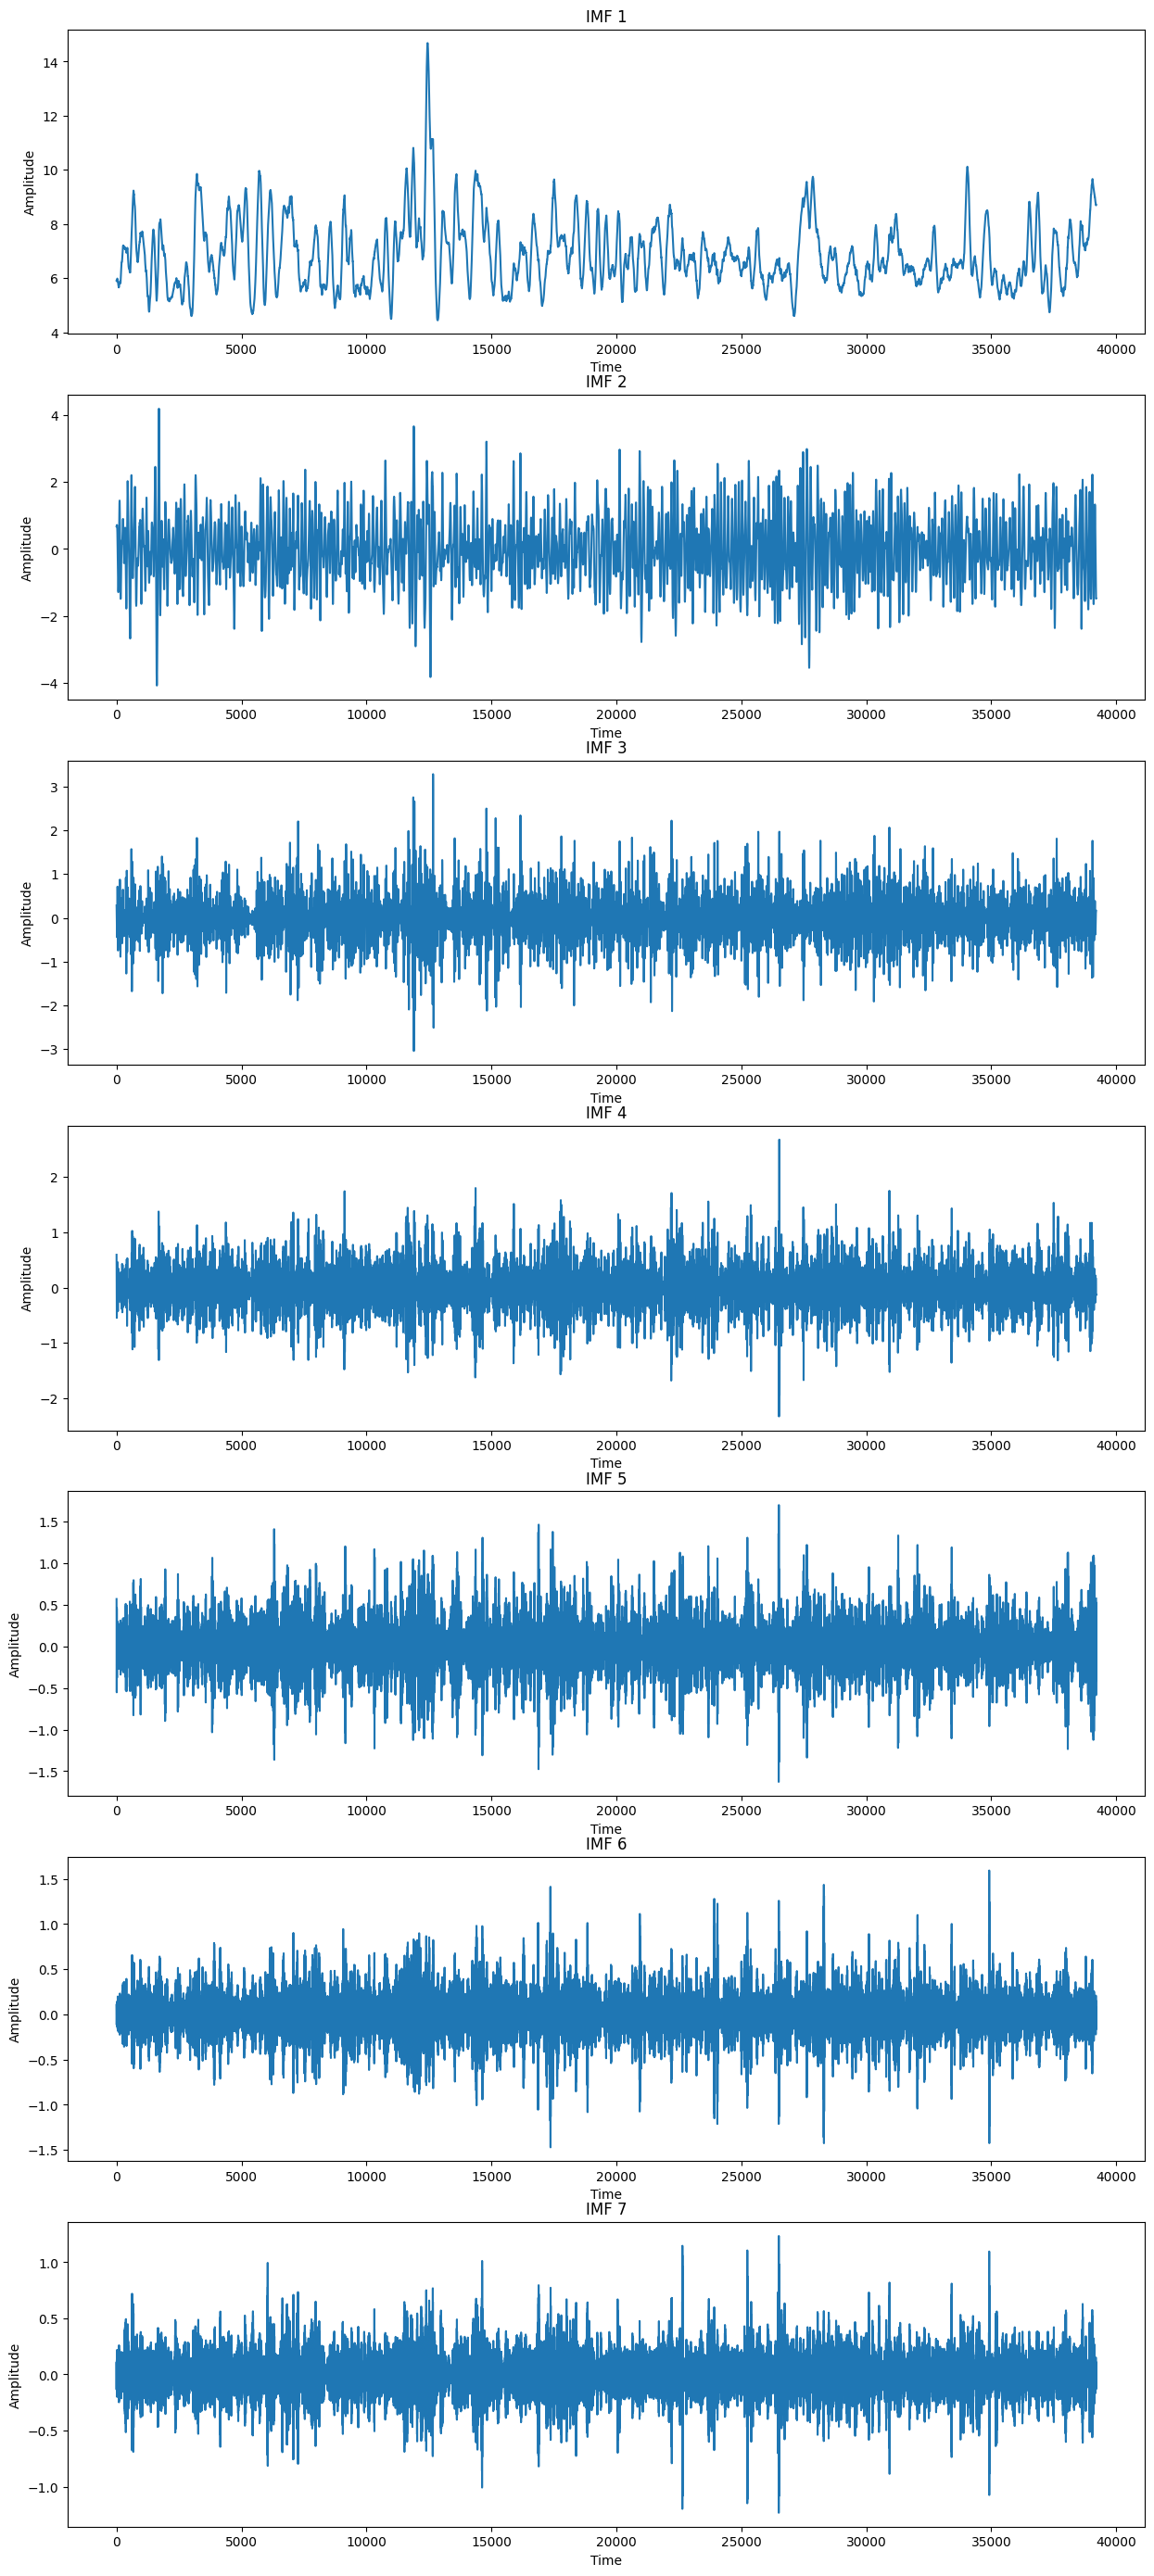

In [13]:
plt.figure(figsize=(15, 5*K))
for k in range(K):
    plt.subplot(K, 1, k+1)
    plt.plot(u[k])
    plt.title(f'IMF {k+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()


In [14]:
import numpy as np

# Convert the list of IMFs to a NumPy array
imfs_array = np.array(u)

In [15]:
imfs_array

array([[ 5.8967531 ,  5.89651402,  5.89278299, ...,  8.68876101,
         8.69036917,  8.6964802 ],
       [ 0.67985083,  0.67942852,  0.67523769, ..., -1.48007114,
        -1.48876974, -1.48744293],
       [ 0.28451071,  0.27106493,  0.24111038, ...,  0.14659011,
         0.15356339,  0.16357791],
       ...,
       [ 0.56907599,  0.43492994,  0.19435574, ...,  0.10508521,
         0.39427725,  0.57512092],
       [ 0.10507359,  0.0623644 , -0.01437347, ...,  0.06606378,
         0.00891527, -0.02442211],
       [ 0.10693398, -0.03114082, -0.13358499, ..., -0.01030286,
        -0.04577143,  0.02502736]])

In [16]:
imfs_array = imfs_array.T

In [17]:
imfs_array

array([[ 5.8967531 ,  0.67985083,  0.28451071, ...,  0.56907599,
         0.10507359,  0.10693398],
       [ 5.89651402,  0.67942852,  0.27106493, ...,  0.43492994,
         0.0623644 , -0.03114082],
       [ 5.89278299,  0.67523769,  0.24111038, ...,  0.19435574,
        -0.01437347, -0.13358499],
       ...,
       [ 8.68876101, -1.48007114,  0.14659011, ...,  0.10508521,
         0.06606378, -0.01030286],
       [ 8.69036917, -1.48876974,  0.15356339, ...,  0.39427725,
         0.00891527, -0.04577143],
       [ 8.6964802 , -1.48744293,  0.16357791, ...,  0.57512092,
        -0.02442211,  0.02502736]])

In [18]:
length=len(imfs_array)
length

39194

In [19]:
DATA = DATA.iloc[:-1]


In [20]:
DATA

,WindSpeed,Power
Time,,
2014-10-07 01:20:00,8.22,40.526173
2014-10-07 01:30:00,8.09,38.552540
2014-10-07 01:50:00,7.21,21.313683
2014-10-07 02:00:00,6.75,18.031418
2014-10-07 02:10:00,6.52,16.593281
...,...,...
2015-10-06 23:00:00,6.78,23.072988
2015-10-06 23:10:00,7.45,30.580953
2015-10-06 23:20:00,7.15,28.455153


In [21]:
DATA = DATA.drop(columns=["WindSpeed"])


In [22]:
DATA

,Power
Time,
2014-10-07 01:20:00,40.526173
2014-10-07 01:30:00,38.552540
2014-10-07 01:50:00,21.313683
2014-10-07 02:00:00,18.031418
2014-10-07 02:10:00,16.593281
...,...
2015-10-06 23:00:00,23.072988
2015-10-06 23:10:00,30.580953
2015-10-06 23:20:00,28.455153


In [23]:
for i in range(K):  # Assuming K is the number of IMFs
   DATA[f'IMF_{i+1}'] = imfs_array[:, i]


In [24]:
target_sensor = "Power"
features = list(DATA.columns.difference([target_sensor]))


forecast_lead = 24
target = f"{target_sensor}_lead{forecast_lead}"

DATA[target] = DATA[target_sensor].shift(-forecast_lead)
df = DATA.iloc[:-forecast_lead]

In [25]:
features

['IMF_1', 'IMF_2', 'IMF_3', 'IMF_4', 'IMF_5', 'IMF_6', 'IMF_7']

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
df_train,df_test = train_test_split(df,test_size=0.3,shuffle= False,random_state=42)

In [29]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev


In [30]:
features

['IMF_1', 'IMF_2', 'IMF_3', 'IMF_4', 'IMF_5', 'IMF_6', 'IMF_7']

In [31]:
target

'Power_lead24'

In [32]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=128):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [33]:
from torch.utils.data import DataLoader

torch.manual_seed(101)

batch_size = 32
sequence_length = 24


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X, y = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 24, 7])
Target shape: torch.Size([32])


In [34]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1
        self.c1 = nn.Conv1d(in_channels=24, out_channels=96, kernel_size = 1, stride = 1)
        self.lstm = nn.LSTM(
            input_size=7,
            hidden_size=150,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)


    def forward(self, x):
        batch_size = x.shape[0]
        x = self.c1(x)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [35]:
learning_rate = 5e-5
num_hidden_units = 150

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [36]:
# Add these lists to store the training and validation losses
train_losses = []
test_losses = []

In [37]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)  # Append the train loss
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    test_losses.append(avg_loss)  # Append the test loss
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(12):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 0.7849375953007004

Epoch 0
---------
Train loss: 0.6958851038262057
Test loss: 0.48241323141543113

Epoch 1
---------
Train loss: 0.5401733384805633
Test loss: 0.42526711334104894

Epoch 2
---------
Train loss: 0.4497517118167432
Test loss: 0.3298239562427625

Epoch 3
---------
Train loss: 0.3039534116900649
Test loss: 0.21693097854174836

Epoch 4
---------
Train loss: 0.24726770896477626
Test loss: 0.19049335236701628

Epoch 5
---------
Train loss: 0.2242501445436283
Test loss: 0.17892885046413817

Epoch 6
---------
Train loss: 0.21448675361369565
Test loss: 0.17056123156394082

Epoch 7
---------
Train loss: 0.2069834368205613
Test loss: 0.16049190139228417

Epoch 8
---------
Train loss: 0.20159631781932075
Test loss: 0.16232864983486134

Epoch 9
---------
Train loss: 0.19715282112325225
Test loss: 0.15794621265218745

Epoch 10
---------
Train loss: 0.19381818479598611
Test loss: 0.16445437927841736

Epoch 11
---------
Train loss: 0.1910057251266657

In [38]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]
df_test_pred = df_test[[target, ystar_col]]
for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
for c in df_test.columns:
    df_test[c] = df_test[c] * target_stdev + target_mean

print(df_test_pred)

                     Power_lead24  Model forecast
Time                                             
2015-06-30 10:30:00     -0.100275        0.108296
2015-06-30 10:40:00      0.087261        0.128912
2015-06-30 10:50:00      0.341580        0.186149
2015-06-30 11:00:00      0.511921        0.288765
2015-06-30 11:10:00      1.236513        0.438052
...                           ...             ...
2015-10-06 19:00:00     -0.320035        0.697775
2015-10-06 19:10:00     -0.040790        0.646735
2015-10-06 19:20:00     -0.119855        0.604468
2015-10-06 19:30:00     -0.059406        0.571825
2015-10-06 19:40:00      0.401908        0.552833

[11751 rows x 2 columns]


In [39]:
from sklearn.metrics import mean_squared_error

# Assuming you have the actual target values in 'actual_targets' and the predictions in 'predictions'
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_test_pred['Power_lead24'], df_test_pred['Model forecast'])

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.15794409070788085


In [40]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_test_pred['Power_lead24'], df_test_pred['Model forecast'])

print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.290524648251102


In [41]:
import math

In [42]:
rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.39742180451993425


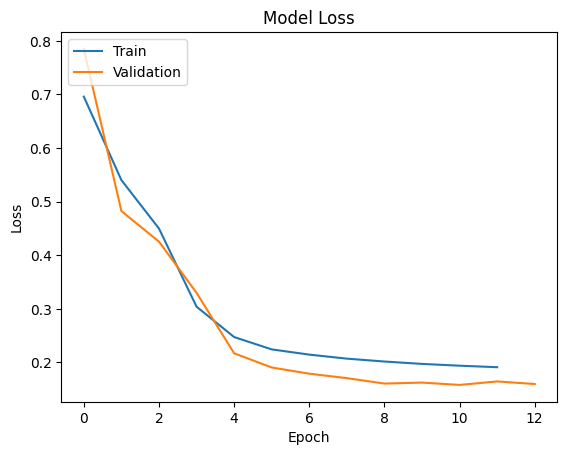

In [43]:
# Plot training & validation loss values
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()